In [6]:
!pip uninstall -y numpy mediapipe tensorflow pandas

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: mediapipe 0.10.21
Uninstalling mediapipe-0.10.21:
  Successfully uninstalled mediapipe-0.10.21
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2


In [1]:
!pip install numpy mediapipe tensorflow pandas

In [15]:
import cv2
import numpy as np
import mediapipe as mp
from google.colab.patches import cv2_imshow
from IPython.display import display, Javascript
from google.colab.output import eval_js
import PIL.Image
import io
import base64

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
    from IPython.display import Javascript
    from google.colab.output import eval_js
    import PIL.Image
    import io, base64

    js = f"""
    async function takePhoto(quality) {{
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = '📸 Take Photo';
        div.appendChild(capture);

        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({{video: true}});
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks().forEach(track => track.stop());
        div.remove();

        return canvas.toDataURL('image/jpeg', quality);
    }}
    takePhoto({quality});
    """

    data = eval_js(js)  # <-- This runs everything only once
    binary = io.BytesIO(base64.b64decode(data.split(',')[1]))
    img = PIL.Image.open(binary)
    img.save(filename)
    return filename


In [17]:
def get_finger_states(hand_landmarks):
    finger_states = []
    tip_ids = [4, 8, 12, 16, 20]

    for i, tip_id in enumerate(tip_ids):
        if i == 0:  # Thumb (x comparison)
            if hand_landmarks.landmark[tip_id].x < hand_landmarks.landmark[tip_id - 1].x:
                finger_states.append(1)
            else:
                finger_states.append(0)
        else:  # Other fingers (y comparison)
            if hand_landmarks.landmark[tip_id].y < hand_landmarks.landmark[tip_id - 2].y:
                finger_states.append(1)
            else:
                finger_states.append(0)
    return finger_states

In [5]:
def classify_gesture(finger_states):
    if finger_states == [0, 0, 0, 0, 0]:
        return "Fist"
    elif finger_states == [1, 1, 1, 1, 1]:
        return "Open Hand"
    elif finger_states == [0, 1, 1, 0, 0]:
        return "Peace"
    elif finger_states == [1, 0, 0, 0, 0]:
        return "Thumbs Up"
    elif finger_states == [0, 1, 0, 0, 0]:
        return "Pointing"
    else:
        return "Unknown"

<IPython.core.display.Javascript object>

Saved to photo.jpg


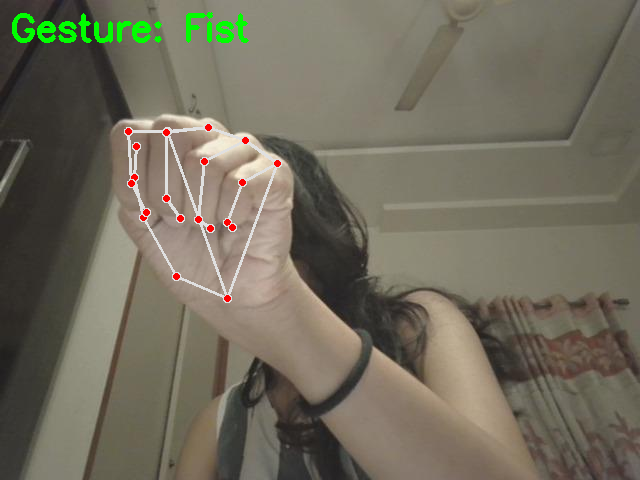

Predicted Gesture: Fist


In [24]:
# Save image
filename = take_photo()
print("Saved to", filename)

# Load and preprocess
image = cv2.imread(filename)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Init MediaPipe
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

with mp_hands.Hands(static_image_mode=True) as hands:
    result = hands.process(rgb)
    if result.multi_hand_landmarks:
        for hand in result.multi_hand_landmarks:
            mp_drawing.draw_landmarks(image, hand, mp_hands.HAND_CONNECTIONS)
            states = get_finger_states(hand)
            gesture = classify_gesture(states)
            cv2.putText(image, f"Gesture: {gesture}", (10, 40),
                        cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)
    else:
        gesture = "No hand detected"
        cv2.putText(image, gesture, (10, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 3)

# Show result
cv2_imshow(image)
print(f"Predicted Gesture: {gesture}")
